* paper - https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
* video - https://www.youtube.com/watch?v=TCH_1BHY58I

上面的pdf就是 MLP 原paper。与我们即将code的MLP不同的是，原paper是在 词-level上进行的；而我们的code将会在 字母-level 上进行搭建 MLP。但是核心思想是一致的。

### 0

#### 0.0. 读数据

In [144]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [145]:
# read in all the words
words = open('./names.txt', 'r').read().splitlines()
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

#### 0.1. 定义映射

`stoi` 和 `itos`

In [146]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [147]:
# build the dataset:

block_size = 3    # context length: how many characters do we take to predict the next character?
X, Y = [], []
for w in words[:5]:     # take the first 5 words:
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '----->', itos[ix])
    context = context[1:] + [ix]      # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... -----> e
..e -----> m
.em -----> m
emm -----> a
mma -----> .
olivia
... -----> o
..o -----> l
.ol -----> i
oli -----> v
liv -----> i
ivi -----> a
via -----> .
ava
... -----> a
..a -----> v
.av -----> a
ava -----> .
isabella
... -----> i
..i -----> s
.is -----> a
isa -----> b
sab -----> e
abe -----> l
bel -----> l
ell -----> a
lla -----> .
sophia
... -----> s
..s -----> o
.so -----> p
sop -----> h
oph -----> i
phi -----> a
hia -----> .


In [148]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

* `X` - 输入字符的索引，长度与`block_size`有关。例如 abc -> 就是 (1, 2, 3)
* `Y` - 紧跟在`X`后面的那个字符的索引（长度为1）。例如 d -> 就是(4)

### 1. 论文
#### 1.1. Context
下面我们初始化一个 lookup table `C`，且假设它有 2列。<span style="color: cyan">我目前对于`C`的作用的理解是：它相当于一个词相似度的查询表，通过该表，你可以通过词相似度将原本的高维矩阵 降维。例如这里我们就降维成了 2列</span>
```python
C = torch.randn((27, 2))
```

In [149]:
C = torch.randn((27, 2))    # lookup table, start with an exmaple of 2 columns
C[5]

tensor([ 1.7508, -0.4100])

根据 [这篇论文](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)下图所述，不难发现，该论文所提出的神经网络架构无非就是在传统的MLP的前边添加了一个 Context Layer。所以我们需要上面的`C` 这个lookup table。


![imge](./img/Screenshot%202024-08-13%20at%2014.46.05.png)

<p style="font-size:18px">关于PyTorch中Tensor的索引规则</span>

`X` 是 32 x 3 的矩阵，其元素是 某个 字符串block 中每个字符的 index
`C` 是 27 x 2的随机矩阵。例如: `[[1, 2], [3, 4], [5, 6], ...]`
在介绍`C[X]`的结果之前先来看一下PyTorch中Tensor的索引规则： 
`C[[0, 0, 0]]` 给出的就是 3 x 2 的矩阵，该矩阵的元素是 C 矩阵的第 0 行，第 0 行，第 0 行。`[[1, 2], [1, 2], [1, 2]]`
如果是 `C[[0, 0, 2], [1, 1, 1]]`，则给出的结果是 3 x 1的矩阵，`[2, 2, 6]` （第0行第1列，第0行第1列，第2行第1列）
那么`C[X]` 给出的是什么？——给出的是一个 32 x 3 x 2 的矩阵。举个例子：

```python
C = torch.tensor([[1, 2], [3, 4], [5, 6]], )
X = torch.tensor([[0, 0, 0], [1, 1, 1], [2, 2, 2], [0, 1, 2]])
>>> C[X] = [[[1, 2],[1, 2],[1, 2]],
            [[3, 4],[3, 4],[3, 4]],
            [[5, 6],[5, 6],[5, 6]],
            [[1, 2],[3, 4],[5, 6]]]
```


#### 1.2. Embedding

In [150]:
emb = C[X]    # 形状应该是 32 x 3 x 2
emb.shape 

torch.Size([32, 3, 2])

embedding之后得到的是 `emb` 这个 32 x 3 x 2 的矩阵。根据上面的论文，它需要与权重矩阵 `W1` 做矩阵乘法。由于 3 x 2 = 6，所以我们需要的`W1` 应该是一个 6 行的矩阵。至于列数，我们假设是100 列。此外还需要加上一个 bias 列 `b1`

我们希望进行的是 `emb @ W1 + b1`。但不难发现 `emb` 和 `W1` 形状不匹配而无法直接矩阵相乘。
我们可以这样做：</br>
```python
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1)
```

或者

```python
torch.cat(torch.unbind(emb, dim=1), dim=1)
``` 

[torch.unbind()](https://pytorch.org/docs/stable/generated/torch.unbind.html)</br>
[torch.cat()](https://pytorch.org/docs/stable/generated/torch.cat.html)

Karpathy 推荐的做法是使用 [torch.view()](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html) 方法。简单理解，该方法就类似于SQL 中的 view，相当于是一个临时的数据 。在内存的使用上它<span style="font-size:18px">非常</span>节省。所以上面给出的两种代码还可以这样写：

```python
emb.view(32, 6)
```

如果你好奇，可以这样对比他们的输出结果：
```python
emb.view(32, 6) == torch.cat(torch.unbind(emb, dim=1), dim=1)
```

最后我们整理一下我们需要的 神经网络的第一层就是：
```python
emb.view(32, 6) @ W1 + b1
```

#### 1.3. 搭建神经网络

In [151]:
W1 = torch.randn((6, 100))    # 6 x 100 矩阵
b1 = torch.randn((1, 100))    # 1 x 100 矩阵
h = emb.view(32, 6) @ W1 + b1
h.shape

torch.Size([32, 100])

创建神经网络的最后一层。权重矩阵`W2`应该是 100 x 27 的。100来自于上一层，27是因为我们有27个字符。

所以

```python 
logits = h @ W2 + b2
```

，`h`就是上一层的输出结果（32 x 100）

In [152]:
W2 = torch.rand((100, 27))
b2 = torch.randn(27)

logits = h @ W2 + b2

logits.shape

torch.Size([32, 27])

计算下一个应该出现的字符的概率和 loss

In [153]:
counts = logits.exp()                               # e^logits
prob = counts / counts.sum(axis=1, keepdims=True)   # normalize probability by counts
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(12.6807)

上面一系列的计算与 PyTorch中的 `.cross_entropy()`方法给出的结果是一样的。

PyTorch 更好的地方在于，它更加节省空间且考虑了算法的并行，所以更省时间。

In [154]:
F.cross_entropy(logits, Y)

tensor(12.6807)

所以我们将整个 1.3. 部分的 神经网络的 搭建过程简化如下：

In [155]:
# forward pass
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)     # (32, 100)
logits = h @ W2 + b2                          # (32, 27)

# 如下是计算cross entropy 的 被简化的部分：
# counts = logits.exp()
# prob = counts / counts.sum(axis=1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()

loss = F.cross_entropy(logits, Y)             # 通过比较 真实值Y 和计算得到的 logits 计算 cross entropy
loss                                          # 这里的值可能与上面的不同

tensor(5.4425)

#### 1.4. 搭建和训练神经网络

In [156]:
# 将所有参数的 “梯度” 设置为True
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True 

for _ in range(10):
  # forward pass
  emb = C[X]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)     # (32, 100)
  logits = h @ W2 + b2                          # (32, 27)
  loss = F.cross_entropy(logits, Y)             # 通过比较 真实值Y 和计算得到的 logits 计算 cross entropy
  print(loss.item())                            # 这里的值可能与上面的不同

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad


5.442534446716309
4.849839210510254
4.320061683654785
3.8538432121276855
3.454399824142456
3.1207871437072754
2.848634719848633
2.629891872406006
2.4528212547302246
2.3055264949798584


这个神经网络很容易fit，是因为我们的输入只有32个。而我们的参数的个数有3481个
```python
sum(p.nelement() for p in parameters) # number of parameters
>>> 3481
```

我们单选出 logits第一行的最大值与 真实值 `Y`对比如下。可以发现大部分都是匹配的。不匹配的几个的主要原因是，在最一开始的时候我们有:

... ---> e
... ---> m
... ---> m
... ---> a

这就导致神经网络不知道 `...` 到底该如何匹配。此外，由于到目前为止的神经网络的input是只有 emma 这一个人的。但如果我们将所有人名都input进来，那么3481个参数就不够了。


In [157]:
logits.max(1), Y

(torch.return_types.max(
 values=tensor([ 3.3145,  1.3359,  5.2056, 10.7195,  1.0646,  3.3145,  4.9016,  4.6791,
         -5.5881, -2.8959, -0.9856, -3.1227,  3.3145,  1.3771,  6.5715,  3.3018,
          3.3145,  2.2145,  5.5291,  2.7120,  3.9454,  2.0245,  2.3574,  5.4360,
         -4.7558,  3.3145,  3.0180,  6.7763,  6.1226,  2.3978, -3.6548, -3.2720],
        grad_fn=<MaxBackward0>),
 indices=tensor([15, 13, 12, 18,  0, 15, 19,  1,  0,  0,  1,  0, 15,  5, 12,  1, 15, 16,
          3, 11, 12, 12,  1,  1,  0, 15, 15, 16,  1, 26,  1,  0])),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

#### 1.5. 将所有人名放入神经网络进行训练 + Mini-batch

下面的部分我们引入了 Mini-batch 的方法来加速训练。它的原理简单来说就是我们在每次训练的周期上，只挑选出原数据的一小部分进行训练。我们的原数据 `X.shape[0]` 是228146。Mini-batch之后数据量变小。下面的具体做法是
```python
ix = torch.randint(0, X.shape[0], (32, ))     # 生成32个 [0, 228146) 的随机整数
```
这些生成的随机数可以用作随机索引，从228146个input中挑选出32个随机数据用作当前神经网络的训练。

所以我们不再使用以前的 `C[X]`， `Y`；而是使用 `C[X[ix]]`, `Y[ix]`

In [158]:
# build the dataset:
block_size = 3    # context length: how many characters do we take to predict the next character?
X, Y = [], []
for w in words:     # take all names
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '----->', itos[ix])
    context = context[1:] + [ix]      # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape, X.dtype, Y.shape, Y.dtype)

# 初始化神经网络参数
g = torch.Generator().manual_seed(214783647)
C = torch.randn((27, 2), generator=g)    # lookup table, start with an exmaple of 2 columns
W1 = torch.randn((6, 100), generator=g)    # 6 x 100 矩阵
b1 = torch.randn(100, generator=g)    # 1 x 100 矩阵
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

# 将所有参数的 “梯度” 设置为True
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True 

# 训练神经网络
for _ in range(100):
  # mini-batch
  ix = torch.randint(0, X.shape[0], (32, ))

  # forward pass
  emb = C[X[ix]]                                # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)     # (32, 100)
  logits = h @ W2 + b2                          # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])             # 通过比较 真实值Y 和计算得到的 logits 计算 cross entropy
  # print(loss.item())                            # 这里的值可能与上面的不同

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

print(loss.item())

torch.Size([228146, 3]) torch.int64 torch.Size([228146]) torch.int64
3.6541337966918945


#### 1.6. Learning Rate如何确定？

接下来我们可以尝试1000种不同的 learning rate 的值。稍有不同的是，我们先生成 [0.001, 0.002, 0.003, ..., 1] (包含)  等差数列，然后让概数列作为 10的幂。例如：`10 ** 0.002`。如此一来我们的learning rate就是一个 底数为10 的指数函数。
```python
lre = torch.linspace(0.001, 1, 1000)    # learning rate exponent。生成等差数列 
lrs = 10 ** lre                         # learning rate 
```
我们将计算出来的 learning rate 放到列表 `lri` 中。然后将不同 learning rate所对应的不同的 loss 放到另一个列表 `lossi` 中。为了后续绘图，我们还可以记录`lrei`，也就是每个learning rate所对应的 指数幂。

<span style="color:cyan">下面一个cell的代码与 1.5 的不同只有 定义 learning rate 和 训练神经网络这两部分</span>

最后我们对所有1000 个 learning rate 及其对应的loss 绘图。

In [159]:
# build the dataset:
block_size = 3    # context length: how many characters do we take to predict the next character?
X, Y = [], []
for w in words:     # take all names
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '----->', itos[ix])
    context = context[1:] + [ix]      # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape, X.dtype, Y.shape, Y.dtype)

# 初始化神经网络参数
g = torch.Generator().manual_seed(214783647)
C = torch.randn((27, 2), generator=g)    # lookup table, start with an exmaple of 2 columns
W1 = torch.randn((6, 100), generator=g)    # 6 x 100 矩阵
b1 = torch.randn(100, generator=g)    # 1 x 100 矩阵
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

# 将所有参数的 “梯度” 设置为True
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True 

# 定义 learning rate
lri, lossi, lrei = [], [], []
lre = torch.linspace(0.001, 1, 1000)    # learning rate exponent。生成等差数列 
lrs = 10 ** lre                         # learning rate 

# 训练神经网络
for i in range(1000):
  # mini-batch
  ix = torch.randint(0, X.shape[0], (32, ))

  # forward pass
  emb = C[X[ix]]                                # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)     # (32, 100)
  logits = h @ W2 + b2                          # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])             # 通过比较 真实值Y 和计算得到的 logits 计算 cross entropy
  # print(loss.item())                            # 这里的值可能与上面的不同

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = lrs[i]
  for p in parameters:
    p.data += -0.1 * p.grad

  # track stats:
  lri.append(lr)    # lr is learning rate
  lrei.append(lre[i])
  lossi.append(loss.item())     # 记录每个不同的 learning rate 所对应的 loss

torch.Size([228146, 3]) torch.int64 torch.Size([228146]) torch.int64


Text(0, 0.5, 'loss')

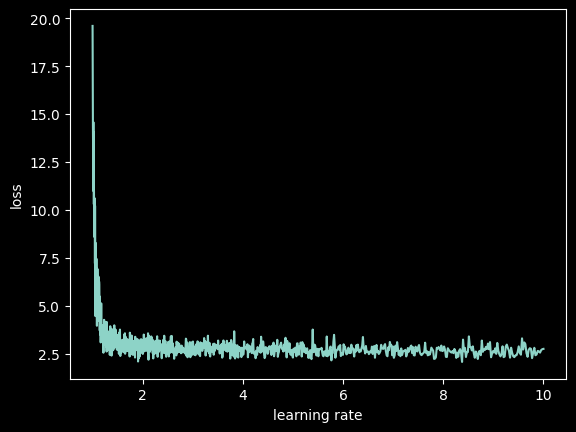

In [160]:
plt.plot(lri, lossi)
plt.xlabel('learning rate')
plt.ylabel('loss')

上面的图比较直观的说明了，当learning rate为 1.0 左右的时候，再继续增大learning rate已经无法继续降低 loss了。

Text(0, 0.5, 'loss')

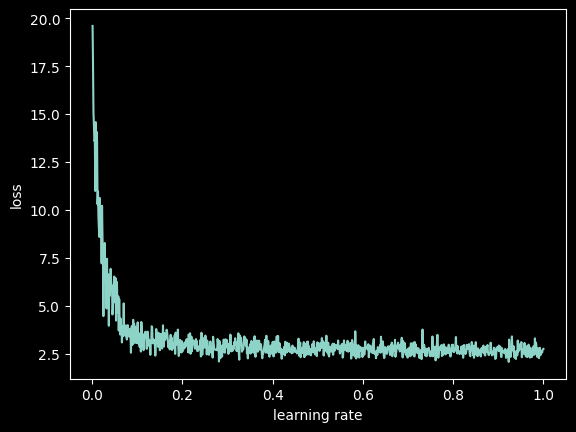

In [161]:
plt.plot(lrei, lossi)
plt.xlabel('learning rate')
plt.ylabel('loss')

这里的图更容易看出，我们应该取 10 ** 0.1

所以我们可以做如下步骤：
1. 把上面的代码中的 learning rate 直接换成 10 ** 0.1 （1.2589左右） 然后运行 10000 次；
2. 之后，将 learning rate 换成 0.1 （减少一个量级），然后再运行 10000 次；
3. 然后，再将 learning rate 换成0.01 （再减少一个量级），运行 10000 次；
Karpathy展示的时候，他的loss会逐步递减到 2.308 左右。但由于这些步骤比较trivial，就不赘述。

接下来我们看:

#### 1.7. Training, Dev/Validation, Testing  (80%, 10%, 10%)

In [162]:
# building the dataset
def build_dataset(words):
  block_size = 3      # context length: how many characters do we take to predict the next one?
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]      # crop and append
  
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


import random
random.seed(42)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [163]:
print('所有人名个数：', len(words), '\n',
      'training set的人名个数：', n1, '\n',
      'dev（也叫validation）set的人名个数：', n2, '\n',
      'testing set的人名个数：', n2 - n1)

所有人名个数： 32033 
 training set的人名个数： 25626 
 dev（也叫validation）set的人名个数： 28829 
 testing set的人名个数： 3203


上面将原数据按照8:1:1 切分之后，我们用training set来训练神经网络。我们将原来的 `X`, `Y`替换成`Xtr`, `Ytr`

In [164]:
# 初始化神经网络参数
g = torch.Generator().manual_seed(214783647)
C = torch.randn((27, 2), generator=g)    # lookup table, start with an exmaple of 2 columns
W1 = torch.randn((6, 100), generator=g)    # 6 x 100 矩阵
b1 = torch.randn(100, generator=g)    # 1 x 100 矩阵
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

# 将所有参数的 “梯度” 设置为True
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True 

# 定义 learning rate
lri, lossi, lrei = [], [], []
lre = torch.linspace(0.001, 1, 1000)    # learning rate exponent。生成等差数列 
lrs = 10 ** lre                         # learning rate 

# 训练神经网络
for i in range(10000):
  # mini-batch
  ix = torch.randint(0, Xtr.shape[0], (32, ))

  # forward pass
  emb = C[Xtr[ix]]                                # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)     # (32, 100)
  logits = h @ W2 + b2                          # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])             # 通过比较 真实值Y 和计算得到的 logits 计算 cross entropy
  # print(loss.item())                            # 这里的值可能与上面的不同

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # # track stats:
  # lri.append(lr)    # lr is learning rate
  # lrei.append(lre[i])
  # lossi.append(loss.item())     # 记录每个不同的 learning rate 所对应的 loss

print(loss.item())

2.650273084640503


In [165]:
# check out training loss
emb = C[Xtr]                               # 32, 3, 2
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # (32, 100)
logits = h @ W2 + b2                        # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.4904837608337402


In [166]:
# check out validation loss
emb = C[Xdev]                               # 32, 3, 2
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # (32, 100)
logits = h @ W2 + b2                        # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.6563947200775146


你可以多次运行上面三个 cell的代码 看神经网络在training, validation, testing上的表现

当三者的 loss 相差不大的时候就可以进行下一步了。（Karpathy的结果是 training上 2.3313；validation 上2.3318）

接下来我们将增加参数量。我们将 
* `W1` 初始化为 6 x 300 的矩阵，
* `b1` 初始化为 1 x 300 的矩阵，
* `W2` 初始化为 300 x 27 的矩阵，

2.344205856323242


Text(0, 0.5, 'loss')

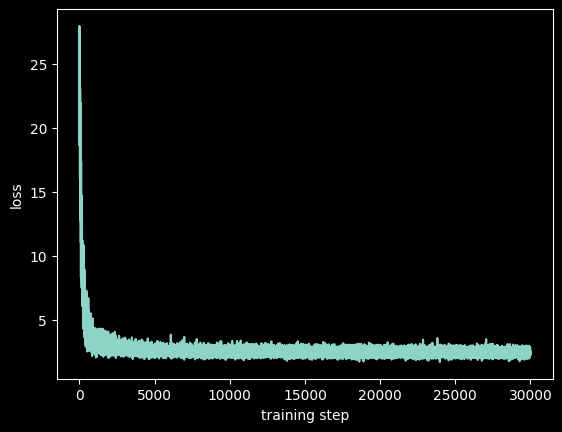

In [167]:
# 初始化神经网络参数
g = torch.Generator().manual_seed(214783647)
C = torch.randn((27, 2), generator=g)    # lookup table, start with an exmaple of 2 columns
W1 = torch.randn((6, 300), generator=g)    # 6 x 100 矩阵
b1 = torch.randn(300, generator=g)    # 1 x 100 矩阵
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)

# 将所有参数的 “梯度” 设置为True
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True 

# 定义 learning rate
stepi, lri, lossi, lrei = [], [], [], []
lre = torch.linspace(0.001, 1, 1000)    # learning rate exponent。生成等差数列 
lrs = 10 ** lre                         # learning rate 

# 训练神经网络
for i in range(30000):
  # mini-batch
  ix = torch.randint(0, Xtr.shape[0], (32, ))

  # forward pass
  emb = C[Xtr[ix]]                                # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)     # (32, 100)
  logits = h @ W2 + b2                          # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])             # 通过比较 真实值Y 和计算得到的 logits 计算 cross entropy
  # print(loss.item())                            # 这里的值可能与上面的不同

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats:
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item())

plt.plot(stepi, lossi)
plt.xlabel('training step')
plt.ylabel('loss')

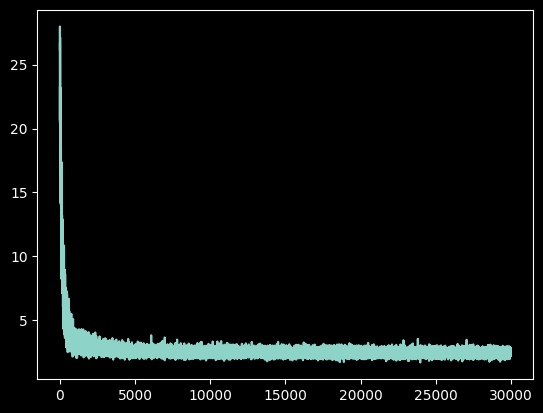

In [168]:
plt.plot(stepi, lossi)

In [169]:
# check out training loss
emb = C[Xtr]                                # 32, 3, 2
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # (32, 300)
logits = h @ W2 + b2                        # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.443737745285034


In [170]:
# check out validation loss
emb = C[Xdev]                               # 32, 3, 2
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # (32, 300)
logits = h @ W2 + b2                        # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.626351833343506


对 embedding vectors进行可视化如下图：

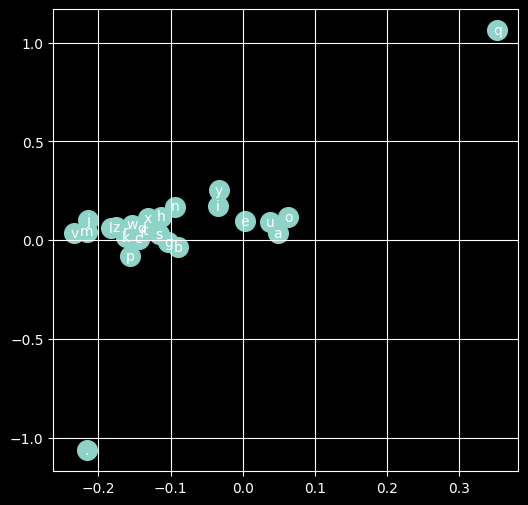

In [171]:
plt.figure(figsize=(6, 6))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], 
           ha='center', va='center', color='white')
plt.grid('minor')

上面的图啥意思呢？

1. 首先你会发现 'q' 这个字母最远。是因为这个字母被模型认为与其他字母的相似度最远
2. 元音字母 'a', 'e', 'i', 'o', 'u' 他们之间距离最近，意味着它们之间在人名的使用中，一定程度上是可以互换的
3. '.' 也非常远。因为这个是特殊字符
4. 剩下所有的字母之间非常近

> 注意，上面的图在每次运行后的结果可能略有不同。
> 1. 例如字母 'y' 有时候会表现出与 'i' 很高的相似度
> 2. 'v', 'j', 'm' 有时候会与其余的 非元音字母 有一小段距离，因为这些在人名中相对不常见。等等

#### 1.8. 进一步调整神经网络的节点个数

将之前的 
* `C = torch.randn((27, 2), generator=g)` 改成了`C = torch.randn((27, 10), generator=g)`
* `W1 = torch.randn((6, 300), generator=g)` 改成了 `W1 = torch.randn((30, 200), generator=g)`
* `b1 = torch.randn(300, generator=g)` 改成了 `b1 = torch.randn(200, generator=g)`
* `W2 = torch.randn((300, 27), generator=g)` 改成了 `W2 = torch.randn((200, 27), generator=g)` 
* `h = torch.tanh(emb.view(-1, 6) @ W1 + b1)` 改成了 `h = torch.tanh(emb.view(-1, 30) @ W1 + b1)`

2.052870035171509


Text(0, 0.5, 'loss')

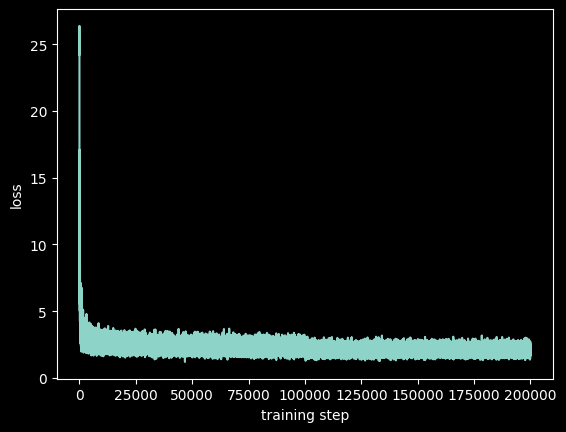

In [176]:
# 初始化神经网络参数
g = torch.Generator().manual_seed(214783647)
C = torch.randn((27, 10), generator=g)    # lookup table, start with an exmaple of 2 columns
W1 = torch.randn((30, 200), generator=g)    # 6 x 100 矩阵
b1 = torch.randn(200, generator=g)    # 1 x 100 矩阵
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

# 将所有参数的 “梯度” 设置为True
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True 

# 定义 learning rate
stepi, lri, lossi, lrei = [], [], [], []
lre = torch.linspace(0.001, 1, 1000)    # learning rate exponent。生成等差数列 
lrs = 10 ** lre                         # learning rate 

# 训练神经网络
for i in range(200000):
  # mini-batch
  ix = torch.randint(0, Xtr.shape[0], (32, ))

  # forward pass
  emb = C[Xtr[ix]]                                # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)      # (32, 200)
  logits = h @ W2 + b2                            # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])         # 通过比较 真实值Y 和计算得到的 logits 计算 cross entropy
  # print(loss.item())                            # 这里的值可能与上面的不同

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats:
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item())

plt.plot(stepi, lossi)
plt.xlabel('training step')
plt.ylabel('loss')

In [177]:
# check out training loss
emb = C[Xtr]                                 # 32, 3, 2
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)   # (32, 200)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.0793838500976562


In [178]:
# check out validation loss
emb = C[Xdev]                                # 32, 3, 2
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)   # (32, 200)
logits = h @ W2 + b2                         # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.4038987159729004


#### 1.9. 用模型生成人名

In [179]:
# sample from the model
g = torch.Generator().manual_seed(214783647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]        # (1, block_size, d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

ryel.
emellaniya.
jaelis.
leia.
olani.
amianne.
malin.
kaedicksoriel.
der.
kel.
hazsen.
reya.
ruison.
kyn.
ladynce.
cori.
aramora.
lomani.
eighailey.
nyi.
